# Choosing the distance thresholds for tracking
The search radius parameterization aims to minimize the number of potential matches by limiting the search window. This should be done based on the physics of sea ice. Alan’s work on the meander coefficient is a great starting point for this. The question is: after an elapsed time oft, how large should the search window be so that we have high confidence that the true floe position will be within the window?

We estimate this from buoy trajectories. We'll estimate the travel distance at 30 min, 1 hr, 90 min, 1 day, 2 day, up to 5 days. 

The processing code is built off of Alan's work from last term. In turn, he adapted code I'd written for the MOSAiC processing. Here, I'll be returning to this code and fixing it so that fewer buoys are rejected. Currently many years have no buoys pass QC.

In [15]:
import os
import pandas as pd
import sys
import pyproj
import numpy as np
import ultraplot as pplt

import importlib
sys.path.append("/Users/dwatkin2/Documents/research/packages/icedrift/src")
import icedrift


In [42]:
dataloc = "/Users/dwatkin2/Documents/research/data/buoy_data/IABP/level_1_data/"
df = convert_iabp(pd.read_csv(dataloc + "LEVEL1_2002.csv"))

Index(['BuoyID', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'Lat',
       'Lon', 'Delay(Min)', 'BPT', 'BP', 'Ts', 'Ta', 'Th', 'Batt'],
      dtype='object')
Index(['buoy_id', 'year', 'month', 'day', 'hour', 'minute', 'second',
       'latitude', 'longitude', 'gps_delay_minutes',
       'barometric_pressure_tendency', 'barometric_pressure',
       'surface_temperature', 'air_temperature', 'hull_temperature',
       'battery_voltage'],
      dtype='object')


<a list of 1 Line2D objects>

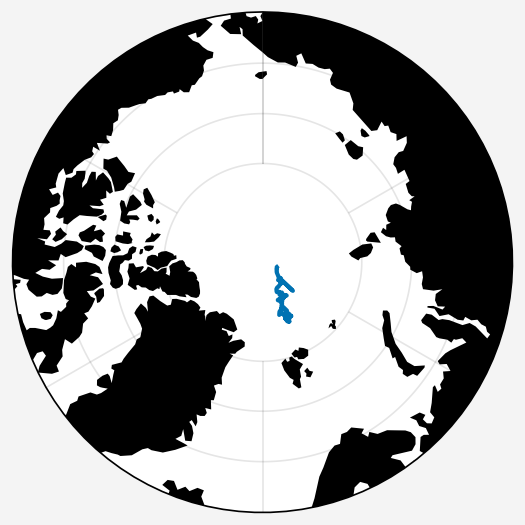

In [44]:
fig, ax = pplt.subplots(proj='npstere')
ax.format(boundinglat=65, land=True)
ax.plot(df.loc[df.buoy_id == 800001].longitude,
        df.loc[df.buoy_id == 800001].latitude)

In [40]:
def convert_level1_iabp(df):
    """Renames columns and converts information to datetime. Masks missing data."""
    print(df.columns)
    df = df.rename({'BuoyID': 'buoy_id',
              'Year': 'year',
              'Month': 'month',
              'Day': 'day',
              'Hour': 'hour',
              'Minute': 'minute',
              'Second': 'second',
              'Lat': 'latitude',
              'Lon': 'longitude',
              'Delay(Min)': 'gps_delay_minutes',
              'BPT': 'barometric_pressure_tendency',
              'BP': 'barometric_pressure',
              'Ts': 'surface_temperature',
              'Ta': 'air_temperature',
              'Th': 'hull_temperature',
              'Batt': 'battery_voltage'
             }, axis=1)
    print(df.columns)
    df['datetime'] = pd.to_datetime({'year': df['year'], 'month': df['month'],
                                     'day': df['day'], 'hour': df['hour'],
                                     'minute': df['minute'], 'second': df['second']})
    return df
                                         

In [85]:
from icedrift import cleaning

df['check_dates'] = cleaning.check_dates(df, date_col='datetime')
df['check_duplicates'] = cleaning.check_positions(df, pairs_only=True)
df['check_gaps'] = cleaning.check_gaps(df, threshold_gap='9h', threshold_segment=12, date_col='datetime')
df['check_speed'] = cleaning.check_speed(df.set_index('datetime'), window='3d', max_speed=1.5, sigma=5).values

In [82]:
print('Data length:', len(df))
print('Date flags:', sum(df['check_dates']))
print('Position flags:', sum(df['check_duplicates']))
print('Gap flags:', sum(df['check_gaps']))

Data length: 4562
Date flags: 0
Position flags: 0
Gap flags: 5


<a list of 1 Line2D objects>

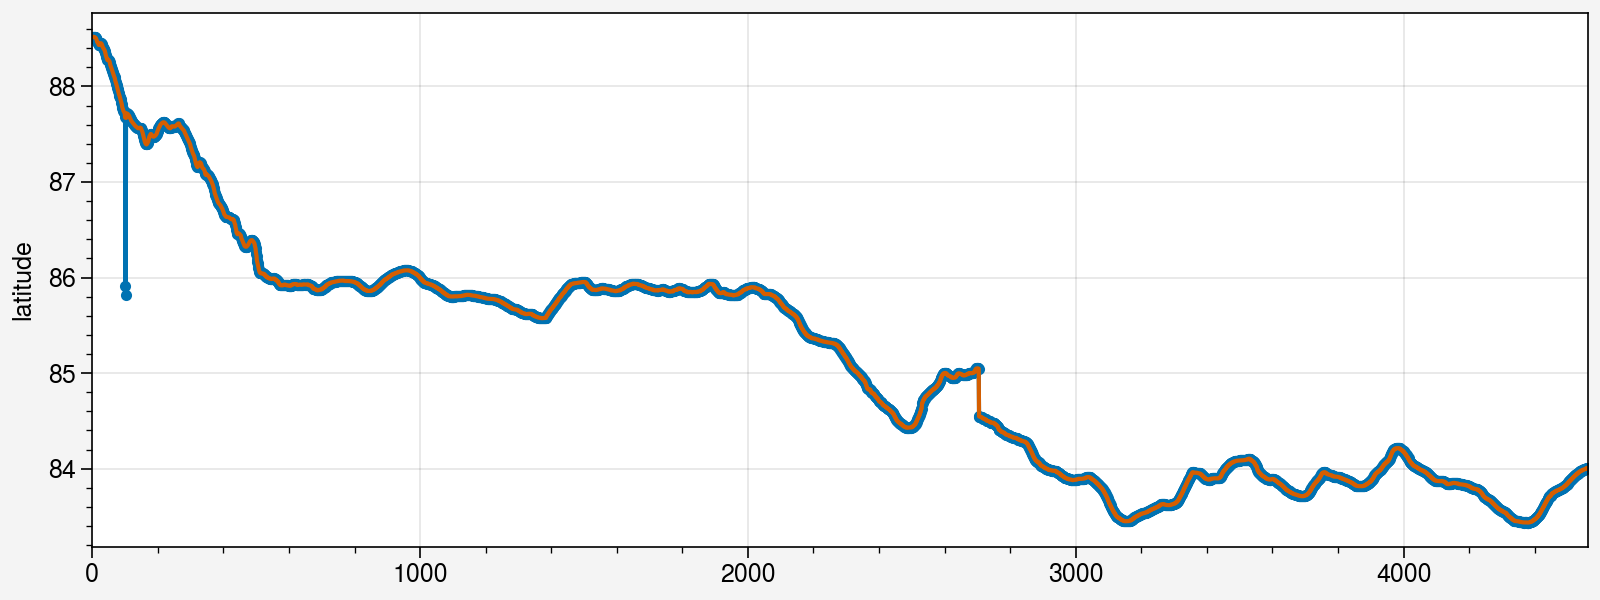

In [88]:
fig, ax = pplt.subplots(width=8, height=3)
ax.plot(df.latitude, marker='.')
# ax.plot(df.latitude.where(df['check_dates'] > 0), marker='.')
# ax.plot(df.latitude.where(df['check_duplicates'] > 0), marker='.')
# ax.plot(df.latitude.where(df['check_gaps'] > 0), marker='.')
# ax.plot(df.latitude.where(df['check_speed'] > 0), marker='.')
# # ax.plot(df.latitude.where(df['check_duplicates'] > 0), marker='.')
# # ax.format(xlim=(1990, 2100))
idx = ~(df['check_dates'] | df['check_duplicates'] | df['check_gaps'] | df['check_speed'])
ax.plot(df.loc[idx, 'latitude'])

In [7]:
import proplot as pplt
save_loc = '../../ift_calval_spr25/data/iabp/clean/'
buoy_data = {}
for year in range(2003, 2022):
    if str(year) in os.listdir(save_loc):
        files = os.listdir(save_loc + str(year))
        print(year, len(files))
        if len(files) > 0:
            buoy_data[year] = {}
            for f in files:
                if '.' != f[0]:
                    buoy_data[year][f.replace('.csv', '')] = pd.read_csv(save_loc + str(year) + '/' + f, parse_dates=True)

2009 1
2010 3
2011 16
2012 23
2013 27
2014 54
2015 102
2016 98


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


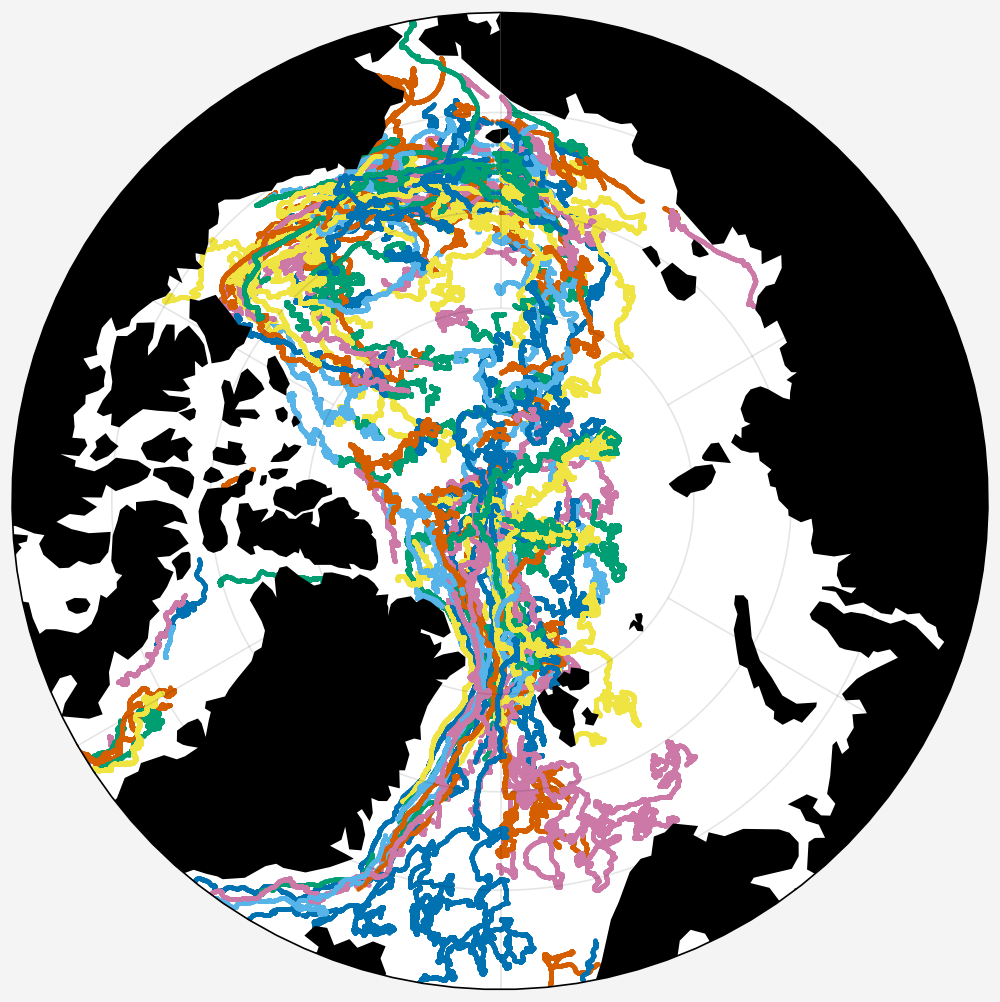

In [8]:
fig, ax = pplt.subplots(proj='npstere', width=5)
ax.format(boundinglat=65, land=True)
for year in buoy_data:
    for buoy in buoy_data[year]:
        ax.scatter(buoy_data[year][buoy].longitude,
                buoy_data[year][buoy].latitude, ms=1)
                

# Finalizing quality control
The quality control isn't perfect, however we should be able to get the worst offenders out. There are a few, like the zigzag through the Fram Strait, that might need manual intervention. The next steps are
1. Select only data that is within the sea-ice covered region. Method: NSIDC CDR SIC Monthly Average needs to be above 0.15 and not in the coastal mask.
2. Division of data into regions: Central Arctic, some number of sectors. Check number of data points in each.
3. Calculate distribution of distances by year.

In [90]:
year = 2009
import xarray as xr
ds_sic = xr.open_dataset('../data/nsidc_sic_cdr/nsidc_cdr_sic_{y}.nc'.format(y=year))

In [28]:
ds_sic.where(ds_sic['cdr_seaice_conc_monthly_qa_flag'] == 5)['cdr_seaice_conc_monthly'].max()

<xarray.DataArray 'cdr_seaice_conc_monthly' ()>
array(0.29999998, dtype=float32)

In [50]:
def sic_along_track_monthly(position_data, sic_data, year):
    """Uses the xarray advanced interpolation to get along-track sic
    via nearest neighbors."""
    
    # Sea ice concentration uses NSIDC NP Stereographic
    crs0 = pyproj.CRS('WGS84')
    crs1 = pyproj.CRS('+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +a=6378273 +b=6356889.449 +units=m +no_defs')
    transformer_stere = pyproj.Transformer.from_crs(crs0, crs_to=crs1, always_xy=True)
    
    sic = pd.Series(data=np.nan, index=position_data.index)
    
    for month, group in position_data.groupby(position_data.datetime.dt.month):
        x_stere, y_stere = transformer_stere.transform(
            group.longitude, group.latitude)
        
        x = xr.DataArray(x_stere, dims="z")
        y = xr.DataArray(y_stere, dims="z")
        date = "{y}-{m}-01".format(y=year, m=month)
        SIC = sic_data.sel(time=date)['cdr_seaice_conc_monthly'].interp(
            {'x': x,
             'y': y}, method='nearest').data

        sic.loc[group.index] = np.round(SIC.T, 3)
    sic[sic >= 1] = np.nan
    return sic

# Process
1. Try selecting by sea ice concentration for the month
2. Try selecting based on distance to ice edge
   

In [62]:
for year in buoy_data:
    with xr.open_dataset('../../ift_calval_spr25/data/nsidc_agg/nsidc_cdr_sic_{y}.nc'.format(y=year)) as ds_sic:
        for buoy in buoy_data[year]:
            df = buoy_data[year][buoy]
            df['datetime'] = pd.to_datetime(df['datetime'].values)
            df['sic_monthly'] = sic_along_track_monthly(df, ds_sic, year)

/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/pyproj/transformer.py:820: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return self._transformer._transform_point(


/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


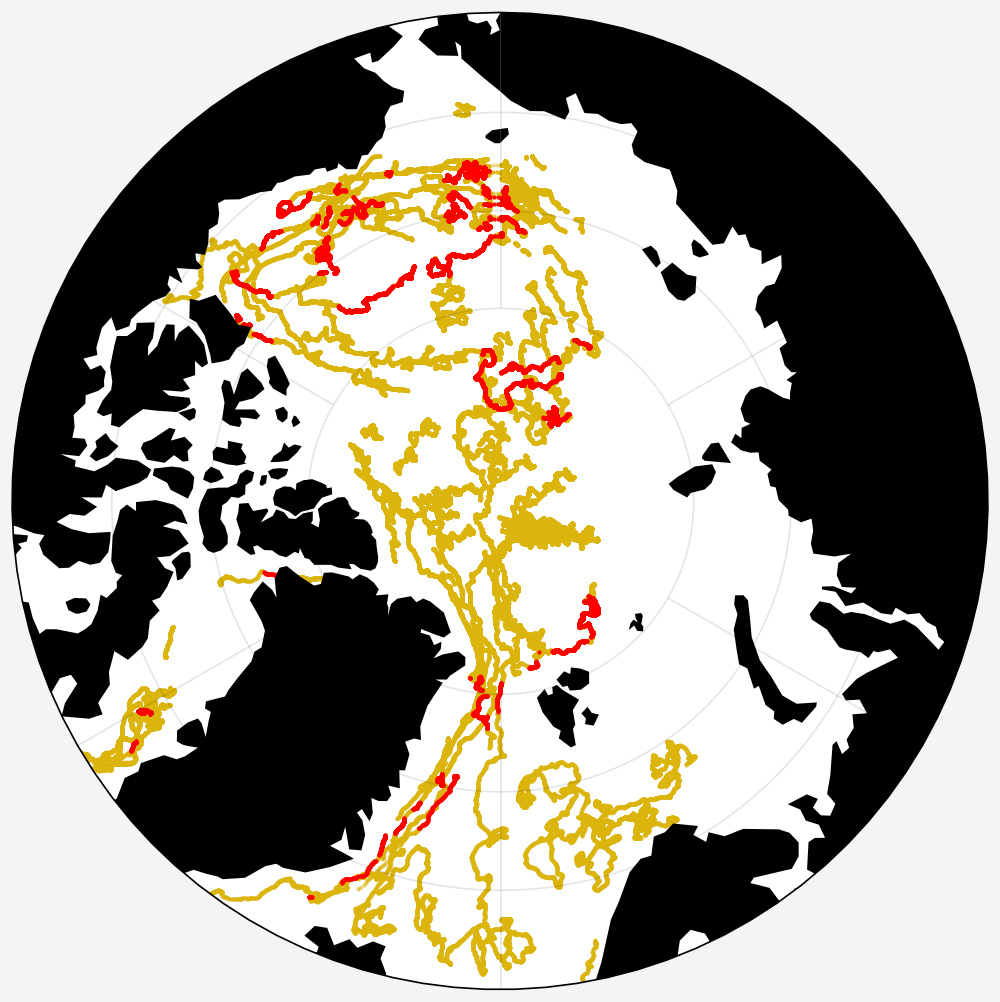

In [181]:
fig, ax = pplt.subplots(proj='npstere', width=5)
ax.format(boundinglat=65, land=True)
for buoy in buoy_data[year]:
    df = buoy_data[year][buoy]
    ax.plot(df.longitude, df.latitude, marker='.', ms=1, color='gold', lw=0,
            zorder=0, alpha=0.5)
    ax.plot(df.loc[df.sic_monthly.between(0.15, 0.8), 'longitude'].values,
            df.loc[df.sic_monthly.between(0.15, 0.8), 'latitude'].values,
            marker='.', color='r', lw=0, zorder=1, ms=1)

In [182]:
import pyproj
g = pyproj.Geod(ellps='WGS84')

df = buoy_data[year][buoy].set_index('datetime')
count = 0
results = {}
for year in buoy_data:
    for buoy in buoy_data[year]:
        df = buoy_data[year][buoy].set_index('datetime')
        if np.any(df.sic_monthly.between(0.15, 0.8)):
            count += 1
            for hours in (1, 3, 6, 12, 24, 48, 72, 96):
                if hours not in results:
                    results[hours] = []
                df_samp = df.resample('{t}h'.format(t=hours)).asfreq()
                
                fwd, bck, dist = g.inv(df_samp.longitude, df_samp.latitude, df_samp.shift(1).longitude, df_samp.shift(1).latitude)
                
                # dist = dist[~np.isnan(dist)]
                df_samp['distance'] = dist
                df_samp['dt'] = hours
                results[hours].append(df_samp)
                # results.append([np.median(dist), np.mean(dist), np.quantile(dist, 0.75), np.quantile(dist, 0.99)])
                # results = pd.DataFrame(results, columns=['median', 'mean', 'q75', 'q99'], index=[1, 3, 6, 12, 24, 48])
            

In [187]:
for hour in results:
    df = pd.concat(results[hour])
    print(hour, len(df.loc[df.sic_monthly.between(0.15, 0.8)].dropna(subset='distance')))

1 85411
3 28692
6 14652
12 7280
24 3623
48 1787
72 1176
96 869


In [183]:
count



140

In [150]:
temp = []
for hour in results:
    dfr = pd.concat(results[hour])

    dfh = pd.DataFrame({
              'mean': dfr.loc[dfr.sic_monthly.between(0.15, 0.88)][['distance']].mean(),
              'q01': dfr.loc[dfr.sic_monthly.between(0.15, 0.88)][['distance']].quantile(0.01),                        
              'q25': dfr.loc[dfr.sic_monthly.between(0.15, 0.88)][['distance']].quantile(0.25),
              'median': dfr.loc[dfr.sic_monthly.between(0.15, 0.88)][['distance']].median(),
              'q75': dfr.loc[dfr.sic_monthly.between(0.15, 0.88)][['distance']].quantile(0.75),
              'q99': dfr.loc[dfr.sic_monthly.between(0.15, 0.88)][['distance']].quantile(0.99)})
    dfh.index = [hour]
    temp.append(dfh)
plot_df = pd.concat(temp)

In [151]:
plot_df['q99'] / 1000 / plot_df.index

1     2.696414
3     2.622106
6     2.549060
12    2.545764
24    2.452617
48    2.091691
72    1.984277
96    1.926155
dtype: float64

In [166]:
plot_df['q99']/(plot_df.index * 60 * 60)

1     0.749004
3     0.728363
6     0.708072
12    0.707157
24    0.681282
48    0.581025
72    0.551188
96    0.535043
dtype: float64

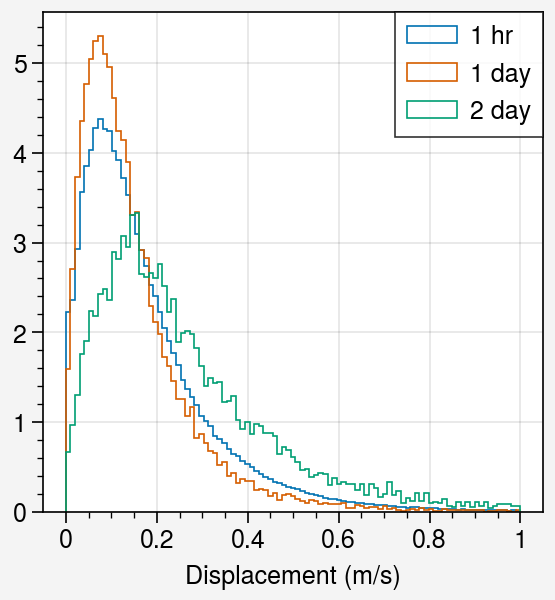

In [180]:
fig, ax = pplt.subplots()
_ = ax.hist(pd.concat(results[1])['distance'].dropna()/(60*60),
       bins=np.linspace(0, 1, 100), density=True, histtype='step', label='1 hr')
_ = ax.hist(pd.concat(results[24])['distance'].dropna()/(24*60*60),
       bins=np.linspace(0, 1, 100), density=True, histtype='step', label='1 day')
_ = ax.hist(pd.concat(results[48])['distance'].dropna()/(24*60*60),
       bins=np.linspace(0, 1, 100), density=True, histtype='step', label='2 day')
ax.legend(ncols=1)
ax.format(xlabel='Displacement (m/s)')

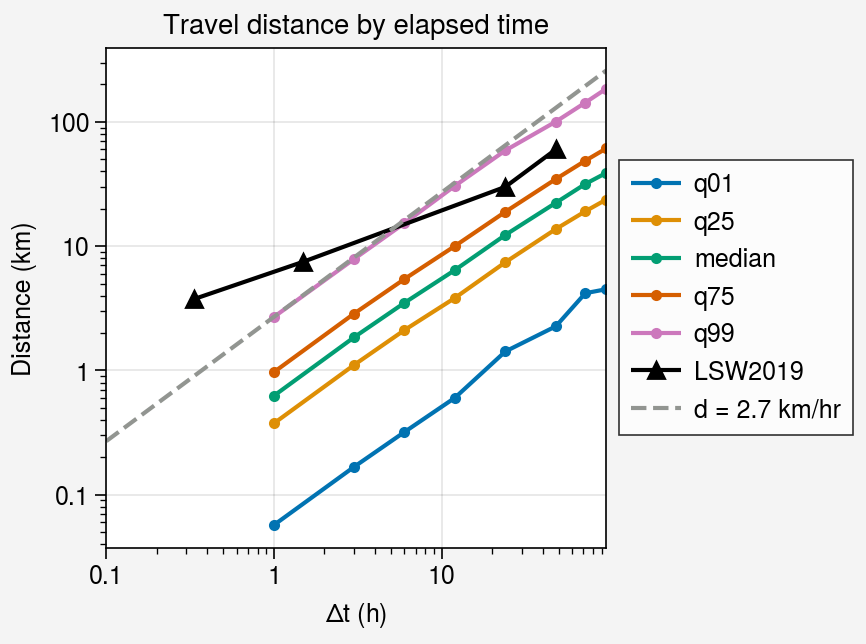

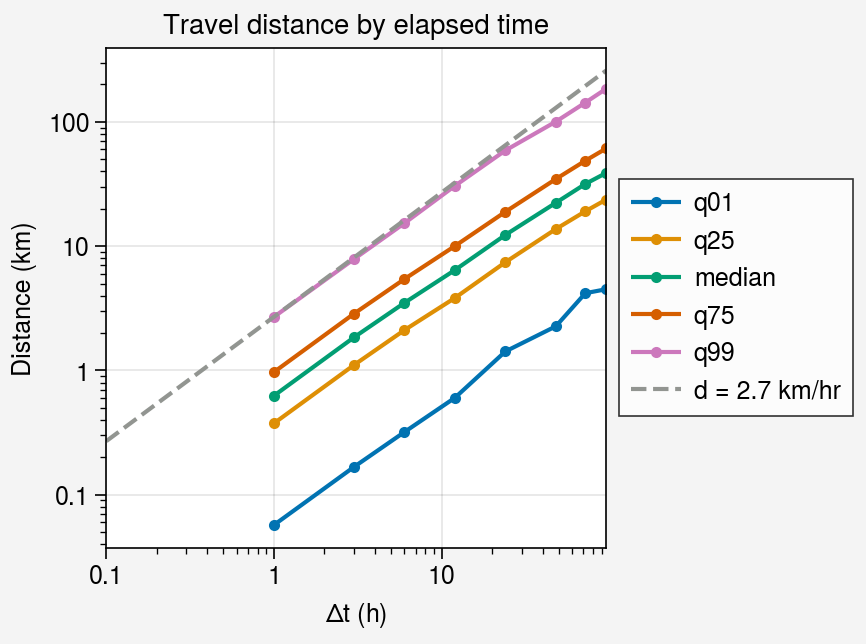

In [163]:
fig, ax = pplt.subplots()
percentiles = ['q01', 'q25', 'median', 'q75', 'q99']
ax.plot(plot_df[percentiles]/1e3, marker='.', cycle='colorblind10')
ax.plot([1/3, 1.5, 24, 48], [3.75, 7.5, 30, 60], color='k', m='^', label='LSW2019 ')
alpha = 2.7 # km/hr
ax.plot(np.linspace(0.1, 96), alpha*np.linspace(0.1, 96), color='gray', ls='--', label='d = 2.7 km/hr')
ax.legend(loc='r', ncols=1)
ax.format(ylabel='Distance (km)', xlabel='$\Delta t$ (h)')

ax.format(yscale='log', title='Travel distance by elapsed time', xscale='log')
fig.save('../figures/travel_distance_with_2019.png', dpi=300)

fig, ax = pplt.subplots()
percentiles = ['q01', 'q25', 'median', 'q75', 'q99']
ax.plot(plot_df[percentiles]/1e3, marker='.', cycle='colorblind10')
# ax.plot([1/3, 1.5, 24, 48], [3.75, 7.5, 30, 60], color='k', m='^', label='LSW2019 ')
alpha = 2.7 # km/hr
ax.plot(np.linspace(0.1, 96), alpha*np.linspace(0.1, 96), color='gray', ls='--', label='d = 2.7 km/hr')
ax.legend(loc='r', ncols=1)
ax.format(ylabel='Distance (km)', xlabel='$\Delta t$ (h)')

ax.format(yscale='log', title='Travel distance by elapsed time', xscale='log')
fig.save('../figures/travel_distance.png', dpi=300)